# Bank Classification Project - Pipelines & Ensembles

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from itertools import cycle
from scipy import interp

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC

from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
# Load data
bank_data = pd.read_csv('data/bank-additional/bank-additional-full.csv', 
                        sep=';', na_values=['NA'])

In [3]:
# Set numerical and categorial
num_attribs = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
           'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_attribs = ['job', 'marital', 'education', 'default', 'housing', 'loan',
               'contact', 'month', 'day_of_week', 'poutcome']

In [4]:
# Get dummies, due to issue with sklearn - https://github.com/jpmml/sklearn2pmml/issues/36
bank_data = pd.get_dummies(bank_data, columns=cat_attribs)
cat_attribs = list(bank_data.columns[11:])

In [5]:
# Stratified train test split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(bank_data, bank_data["y"]):
    strat_train_set = bank_data.loc[train_index]
    strat_test_set = bank_data.loc[test_index]

In [6]:
bank = strat_train_set.drop("y", axis=1)
bank_labels = strat_train_set["y"].copy()

In [7]:
# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [8]:
# Issue with sklearn 
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [9]:
bank_prepared = full_pipeline.fit_transform(bank)
bank_prepared

array([[ 0.86373877,  0.52298128,  0.19658384, ...,  0.        ,
         1.        ,  0.        ],
       [-0.28972159, -0.20368791,  0.19658384, ...,  1.        ,
         0.        ,  0.        ],
       [ 3.65126795, -0.56702251,  0.19658384, ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [ 1.34434725,  0.52298128,  0.19658384, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05869515, -0.56702251,  0.19658384, ...,  0.        ,
         1.        ,  0.        ],
       [-0.48196498,  0.15964669,  0.19658384, ...,  0.        ,
         1.        ,  0.        ]])

In [10]:
bank_prepared[0]

array([ 0.86373877,  0.52298128,  0.19658384, -0.35012691, -0.11485842,
       -0.64896664, -0.32226925,  0.28896439,  0.3989903 ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ])

*Lots of Dimensions.*

## Bernoulli Trials

In [11]:
bank_bernoulli = bank_prepared[:, 9:]

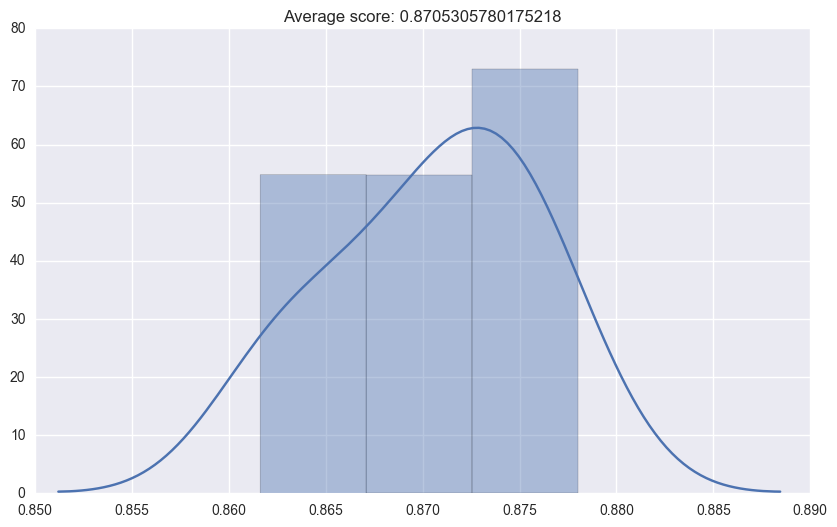

In [12]:
# NB model that assumes data is distribued according to multivariate Bernoulli distributions
cv_scores = cross_val_score(BernoulliNB(), bank_bernoulli, bank_labels, cv=10)
sns.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)));

In [13]:
# Grid search with a stratified KFold
parameter_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5]
}

cross_validation = StratifiedKFold(n_splits=10)

gs = GridSearchCV(BernoulliNB(),
                  param_grid=parameter_grid,
                  cv=cross_validation)

gs.fit(bank_bernoulli, bank_labels)
print('Best score: {}'.format(gs.best_score_))
print('Best parameters: {}'.format(gs.best_params_))

Best score: 0.8709256449165402
Best parameters: {'alpha': 5}


In [14]:
# Nested 5x2 Cross-validation
parameter_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5]
}

gs = GridSearchCV(BernoulliNB(),
                  param_grid=parameter_grid,
                  cv=2)

scores = cross_val_score(gs, bank_bernoulli, bank_labels, scoring='accuracy', cv=5)
print('\nAverage Accuracy %.2f +/- %.2f' % (np.mean(scores), np.std(scores)))


Average Accuracy 0.87 +/- 0.00


In [15]:
X_test = strat_test_set.drop("y", axis=1)
y_test = strat_test_set["y"].copy()

X_test_prepared = full_pipeline.transform(X_test)

In [16]:
gs.fit(bank_bernoulli, bank_labels)
clf = gs.best_estimator_
clf.fit(bank_bernoulli, bank_labels)
print('Test accuracy: %.3f' % clf.score(X_test_prepared[:, 9:], y_test))
y_pred = clf.predict(X_test_prepared[:, 9:])
print('Test recall: %.3f' % recall_score(y_test, y_pred, pos_label="yes"))

Test accuracy: 0.875
Test recall: 0.367


In [17]:
# Set the parameters by cross-validation
tuned_parameters = [{'alpha': [0.001, 0.01, 0.1, 0.5, 1, 2, 5]}]

scores = ['recall', 'precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(BernoulliNB(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(bank_bernoulli, bank_labels)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test_prepared[:, 9:])
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'alpha': 1}

Grid scores on development set:

0.651 (+/-0.014) for {'alpha': 0.001}
0.651 (+/-0.014) for {'alpha': 0.01}
0.651 (+/-0.014) for {'alpha': 0.1}
0.651 (+/-0.014) for {'alpha': 0.5}
0.651 (+/-0.014) for {'alpha': 1}
0.651 (+/-0.014) for {'alpha': 2}
0.651 (+/-0.012) for {'alpha': 5}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

         no       0.92      0.94      0.93      7310
        yes       0.43      0.37      0.40       928

avg / total       0.87      0.87      0.87      8238


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'alpha': 5}

Grid scores on development set:

0.670 (+/-0.024) for {'alpha': 0.001}
0.670 (+/-0.024) for {'alpha': 0.01}
0.670 (+/-0.024) for {'alpha': 0.1}
0.670 (+/-0.024) for

In [18]:
gs.fit(bank_bernoulli, bank_labels)
clf = gs.best_estimator_
clf.fit(bank_bernoulli, bank_labels)
print('Test accuracy: %.3f' % clf.score(X_test_prepared[:, 9:], y_test))
y_pred = clf.predict(X_test_prepared[:, 9:])
print('Test recall: %.3f' % recall_score(y_test, y_pred, pos_label="yes"))

Test accuracy: 0.875
Test recall: 0.367


In [19]:
# play around with decision thresholds
y_labels = BernoulliNB().fit(bank_bernoulli, bank_labels).predict(X_test_prepared[:, 9:])
y_probas = BernoulliNB().fit(bank_bernoulli, bank_labels).predict_proba(X_test_prepared[:, 9:])[:, 1]

In [20]:
# New labels
def update_labels(y, threshold=0.5):
    if y > threshold:
        label = 1
    else:
        label = 0

    return label

In [21]:
# higher recall
new_labels = [update_labels(y, threshold=0.05) for y in list(y_probas)]
y_test_binary = y_test.map(dict(yes=1, no=0)).values

print('Precision: %.3f' % precision_score(y_true=y_test_binary, y_pred=new_labels))
print('Recall: %.3f' % recall_score(y_true=y_test_binary, y_pred=new_labels))
print('F1: %.3f' % f1_score(y_true=y_test_binary, y_pred=new_labels))

Precision: 0.172
Recall: 0.801
F1: 0.283


In [22]:
len(new_labels)

8238

In [23]:
confmat = confusion_matrix(y_true=y_test_binary, y_pred=new_labels)
print(confmat)

[[3732 3578]
 [ 185  743]]


## Ensembles

In [24]:
# Bagging
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True)
bagging.fit(bank_prepared, bank_labels)
y_pred = bagging.predict(X_test_prepared)
print(bagging.__class__.__name__, "Accuracy: ", accuracy_score(y_test, y_pred))
print(bagging.__class__.__name__, "Recall: ", recall_score(y_test, y_pred, pos_label="yes"))

BaggingClassifier Accuracy:  0.900218499636
BaggingClassifier Recall:  0.178879310345


In [25]:
# Pasting
pasting = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=False)
pasting.fit(bank_prepared, bank_labels)
y_pred = pasting.predict(X_test_prepared)
print(pasting.__class__.__name__, "Accuracy: ", accuracy_score(y_test, y_pred))
print(pasting.__class__.__name__, "Recall: ", recall_score(y_test, y_pred, pos_label="yes"))

BaggingClassifier Accuracy:  0.901068220442
BaggingClassifier Recall:  0.207974137931


In [26]:
# Random Forests
rf = RandomForestClassifier(n_estimators=100)
rf.fit(bank_prepared, bank_labels)
y_pred = rf.predict(X_test_prepared)
print(rf.__class__.__name__, "Accuracy: ", accuracy_score(y_test, y_pred))
print(rf.__class__.__name__, "Recall: ", recall_score(y_test, y_pred, pos_label="yes"))

RandomForestClassifier Accuracy:  0.8951201748
RandomForestClassifier Recall:  0.29525862069


In [27]:
# Extremely Randomized Trees
erf = ExtraTreesClassifier(n_estimators=100)
erf.fit(bank_prepared, bank_labels)
y_pred = erf.predict(X_test_prepared)
print(erf.__class__.__name__, "Accuracy: ", accuracy_score(y_test, y_pred))
print(erf.__class__.__name__, "Recall: ", recall_score(y_test, y_pred, pos_label="yes"))

ExtraTreesClassifier Accuracy:  0.882374362709
ExtraTreesClassifier Recall:  0.29525862069


In [28]:
# Majority voting 
log_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier()
rnd_clf = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf)],
    voting='soft'
)

voting_clf.fit(bank_prepared, bank_labels)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))],
         n_jobs=1, voting='soft', weights=None)

In [29]:
for clf in (log_clf, dt_clf, rnd_clf, voting_clf):
    clf.fit(bank_prepared, bank_labels)
    y_pred = clf.predict(X_test_prepared)
    print(clf.__class__.__name__, "Accuracy:", accuracy_score(y_test, y_pred))
    print(clf.__class__.__name__, "Recall:", recall_score(y_test, y_pred, pos_label="yes"))

LogisticRegression Accuracy: 0.901189609128
LogisticRegression Recall: 0.223060344828
DecisionTreeClassifier Accuracy: 0.84158776402
DecisionTreeClassifier Recall: 0.332974137931
RandomForestClassifier Accuracy: 0.893784899247
RandomForestClassifier Recall: 0.274784482759
VotingClassifier Accuracy: 0.900704054382
VotingClassifier Recall: 0.258620689655


In [30]:
# Boosting
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=0)
ada_clf.fit(bank_prepared, bank_labels)
y_pred = ada_clf.predict(X_test_prepared)
print(ada_clf.__class__.__name__, "Accuracy: ", accuracy_score(y_test, y_pred))
print(ada_clf.__class__.__name__, "Recall: ", recall_score(y_test, y_pred, pos_label="yes"))

AdaBoostClassifier Accuracy:  0.902524884681
AdaBoostClassifier Recall:  0.213362068966


In [31]:
gb_clf = GradientBoostingClassifier(max_depth=4, n_estimators=100, learning_rate=1.0, random_state=0)
gb_clf.fit(bank_prepared, bank_labels)
y_pred = gb_clf.predict(X_test_prepared)
print(gb_clf.__class__.__name__, "Accuracy: ", accuracy_score(y_test, y_pred))
print(gb_clf.__class__.__name__, "Recall: ", recall_score(y_test, y_pred, pos_label="yes"))

GradientBoostingClassifier Accuracy:  0.892206846322
GradientBoostingClassifier Recall:  0.292025862069
